# Custom Model Results
This nnotebook collects the data from the different custom model variations in order to compare results and plot the results.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from autograd import grad
import autograd.numpy as anp
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import linear_model, model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

rand = np.random.RandomState(13)

We first import the data and apply the temporal variuables comntaining week information transformed.

In [434]:
data = pd.read_csv('../Data/TFM_Hdataset_clean.csv', index_col=0)


conditions = [(data['Year']!= 2019) & (data['Year']!= 2021),
              (data['Year']== 2019),
              (data['Year']!= 2019)]

vals = [np.sin(2*np.pi*data['Week']/52),
        np.sin(2*np.pi*data['Week']/53),
        np.sin(2*np.pi*data['Week']/50)
       ]

vals2 = [np.cos(2*np.pi*data['Week']/52),
        np.cos(2*np.pi*data['Week']/53),
        np.cos(2*np.pi*data['Week']/50)
       ]
data['Week_sin'] = np.select(conditions,vals)
data['Week_cos'] = np.select(conditions,vals2)


# Channels splitted by country/currency
channel_pound = [ 'Retail - Concessions', 'Retail - Full Price','Retail - Concessions','UK Offline', 'UK Online',
 'Retail - Outlet', 'UK Direct',  'Wholesale', 
 'Digital Partnerships',  'Retail' ]
channel_euro = ['DE Direct','Euro Direct','EU Direct']
channel_dollar = ['US Direct','US Online', 'US Offline']

data['Country'] =  np.select( [
                                    (data['Channel'].isin(channel_pound)),
                                    (data['Channel'].isin(channel_euro)),
                                    (data['Channel'].isin(channel_dollar))
                                ],[
                                    'UK',
                                    'US',
                                    'EU'
                                ])

In [435]:
data_test = data[data['Year']==2019]
data = data[(data['Year']!=2021)&(data['Year']!=2020)&(data['Year']!=2019)]

aggregations = {'Price':'mean',
               'prev_sales_week':'sum', 
                'Week_sin':'mean',
                'Week_cos':'mean',
                'Discount':'mean',
               'sales':'sum'
               }

products = ['Suede And Nubuck Brush',"Hotter Women's Insoles",'Footwear Cleaner','Renovating Cream', 'Wax Oil','Shake','Rutland GTX','Laurel', 'Leanne','Solar','Nova', 'Tone']

data

,Description,Seasonality,Year,Week,Channel,WSSI Category,LIMITED EDITION STYLES,Originals,Source,sales,...,Date,Price,Discount,Margin,RRP,Markdown,Cost,Week_sin,Week_cos,Country
1,Astrid,OLD,2017,1,DE Direct,Womens Active Shoes,0.0,0.0,NONE,1.0,...,2017-01-08,38.526679,0.000000,25.758448,50.378410,11.851731,12.768232,1.205367e-01,0.992709,US
3,Charmaine,SS,2017,1,DE Direct,Womens Formal Shoes,0.0,0.0,NONE,1.0,...,2017-01-08,58.225767,0.000000,44.100962,58.395499,0.169733,14.124805,1.205367e-01,0.992709,US
4,Chile,SS,2017,1,DE Direct,Womens Casual Shoes,0.0,0.0,NONE,1.0,...,2017-01-08,58.225767,0.000000,46.649675,58.395499,0.169733,11.576091,1.205367e-01,0.992709,US
5,Devotion,AW,2017,1,DE Direct,Womens Slippers,0.0,0.0,NONE,2.0,...,2017-01-08,26.457288,0.000000,17.882101,34.688819,8.231530,8.575187,1.205367e-01,0.992709,US
6,Donna,CONT,2017,1,DE Direct,Womens Formal Shoes,0.0,0.0,NONE,1.0,...,2017-01-08,69.982735,0.000000,54.114939,70.192570,0.209836,15.867796,1.205367e-01,0.992709,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181660,Wrap,OLD,2018,52,Wholesale,Womens Slippers,0.0,0.0,MANUFACTURED,1.0,...,2018-12-30,23.950000,1.260000,9.710000,45.833333,20.623333,14.240000,6.432491e-16,1.000000,UK
181661,Wrap,SS,2018,52,Wholesale,Womens Slippers,0.0,0.0,MANUFACTURED,22.0,...,2018-12-30,25.152727,0.057273,11.712727,49.166666,23.956666,13.440000,6.432491e-16,1.000000,UK
181662,Wrap,AW,2018,52,Wholesale,Womens Slippers,0.0,0.0,MANUFACTURED,37.0,...,2018-12-30,17.769459,0.000000,4.329459,49.166666,31.397207,13.440000,6.432491e-16,1.000000,UK
181663,York,AW,2018,52,Wholesale,Womens Formal Boots,0.0,0.0,MANUFACTURED,89.0,...,2018-12-30,31.961461,0.000000,11.904719,79.166666,47.205206,20.056742,6.432491e-16,1.000000,UK


Models used:

In [436]:
#Model for creating the synthetic data
def model1_data(X,w,noise_p):
    noise = anp.random.normal(0,noise_p,X.shape[0])
    y = anp.exp(w[0]-w[1]*(anp.log(X[:,0]))+w[2]*noise)
    return y

#Model to learn
def model1(X,w):
    y = anp.exp(w[0]-w[1]*(anp.log(X[:,0])))
    return y

def model1_res(X,w):
    y = -w[2] + anp.exp(w[0]-w[1]*(anp.log(X[:,0])))#+w[2]*anp.random.normal(0,1,X.shape[0]))
    return y

#Model for creating the synthetic data
def model1_datab(X,w,noise_p):
    noise = anp.random.normal(0,noise_p,X.shape[0])
    y = anp.exp(-w[0]*(anp.log(w[1]*X[:,0]))+w[2]*noise)
    return y

#Model to learn
def model1b(X,w):
    y = anp.exp(w[0]*(anp.log(w[1]*X[:,0])))#+w[2]*anp.random.normal(0,1,X.shape[0]))
    return y

def model2_data(X,w,noise_p):
    noise = anp.random.normal(0,noise_p,X.shape[0])
    beta = w[1]*X[:,1] + w[2]*X[:,2] + w[3]*X[:,3]
    y = anp.exp(w[0]- beta*anp.log(X[:,0]) - beta*(w[4])+w[5]*noise)
    return y

#Model to learn
def model2(X,w):
    beta = w[1]*X[:,1] + w[2]*X[:,2] + w[3]*X[:,3]
    y = anp.exp(w[0]- beta*anp.log(X[:,0])- beta*(w[4]))
    return y

#Model to learn
def model2_res(X,w):
    beta = w[1]*X[:,1] + w[2]*X[:,2] + w[3]*X[:,3]
    y = -w[5] + anp.exp(w[0]- beta*anp.log(X[:,0])- beta*(w[4]))
    return y

def pnew2(X,w):
    p = w[3]*X[:,3] + w[4]*X[:,4] + w[6]*X[:,0]
    return p

def model6b_data(X,w,noise_p):
    noise = anp.random.normal(0,noise_p,X.shape[0])
    p_new = pnew2(X,w)
    beta = w[1]*X[:,1] + w[2]*X[:,2] + w[5]*X[:,3]
    y = anp.exp(w[0] - beta*(anp.log(p_new)) + noise)
    return y


def model6b(X,w):
    p_new = pnew2(X,w)
    beta = w[1]*X[:,1] + w[2]*X[:,2] + w[5]*X[:,3]
    y = anp.exp(w[0] - beta*(anp.log(p_new)))
    return y

Basic Model

In [437]:
#synthetic data preparation
p = rand.uniform(20,50,50)
dades = {'p':p}
sim1 = pd.DataFrame(data=dades)
gen_params = [4.5,0.1,0.1]
est_params = [4.49103494, 0.09647914, 1.]
sim1['d'] = model1_data(sim1.values,gen_params,0.1)
Xsim1 = sim1.values[:,:-1]
dsim1 = sim1.values[:,-1]

#### Real data ####
data_prod = data[(data['Description']=="Footwear Cleaner")&(data['Channel']=='Retail - Full Price')].sort_values('Date')
data_prod_test = data_test[(data_test['Description']=="Footwear Cleaner")&(data_test['Channel']=='Retail - Full Price')].sort_values('Date')

#real data preparation prod 1
data_prod1 = data_prod[['Price','sales']]
data_prod1_test = data_prod_test[['Price','sales']]
X1 = data_prod1.values[:,:-1]
d1 = data_prod1.values[:,-1]
X1_test = data_prod1_test.values[:,:-1]
d1_test = data_prod1_test.values[:,-1]
#est_params_1 = [ 2.14064638, -2.90447567] 
est_params_1 =[-1.37019817, -5.52909902]

#real data preparation prod res1
series = data_prod[['Date','sales']].groupby(['Date']).sum()
result = seasonal_decompose(series, model='additive', period=5)
residual = pd.DataFrame(result.resid)
trend = pd.DataFrame(result.trend)
trend = trend.rename(columns={'trend':'resid'})
desc = residual.add(trend,fill_value=0)
data_prod1res = data_prod.merge(desc, on='Date')
data_prod1res = data_prod1res[['Price', 'resid']]
data_prod1res = data_prod1res.fillna(0)
X1res = data_prod1res.values[:,:-1]
d1res = data_prod1res.values[:,-1]
est_params_1res = [-1.95734561, -5.94558051]


FAM Model

In [438]:
#synthetic data preparation
p = rand.uniform(20,50,50)
q = rand.uniform(0,1,50)
r = rand.uniform(0.01,0.04,50)
s = rand.uniform(0,1,50)
t = rand.uniform(0,1,50)
z = rand.uniform(0,1,50)
dades = {'p':p,'q':q,'r':r,'s':s,'t':t,'z':z}
sim2 = pd.DataFrame(data=dades)
gen_params2 = [2.5, 0.1, 0.8, 0.5, 0.2, 1.1, 0.1]
est_params2 = [ 2.50461658 , 0.09432526 , 0.8301108 ,  0.17715689, -0.02839493,  1.05681985, 0.10694645]

sim2['d'] = model6b_data(sim2.values,gen_params2,0.1)
Xsim2 = sim2.values[:,:-1]
dsim2 = sim2.values[:,-1]

#### Real data ####

#real data preparation prod 1
data_prod2 = data_prod[['Price','Week_sin','Week_cos','Discount','prev_mean_price','sales']]
data_prod2_test = data_prod_test[['Price','Week_sin','Week_cos','Discount','prev_mean_price','sales']] #WOOOOOOOORK with model 10 ['Price','Week_sin','Week_cos','Discount','Markdown','prev_mean_price','sales']
X2 = data_prod2.values[:,:-1]
d2 = data_prod2.values[:,-1]
X2_test = data_prod2_test.values[:,:-1]
d2_test = data_prod2_test.values[:,-1]
#est_params_2 = [ 5.91683184,  0.16150407,  0.74686492,  0.83835534,  0.37606483, -1.10849236, 0.31396614] # W insoles
#est_params_2= [  5.97864351 , -0.16824728 ,  0.27290422 ,  3.49389161, -13.29291604, -0.57011348 ,  1.92186118] #RRP WOOOOOOORK
#est_params_2= [ 5.80978848, -1.0363736,   0.80197338, -0.56797395, -0.95588018, -4.13771596, 0.40041677] #Markdown
#est_params_2= [ 5.80859413, -0.93424582,  0.72224135,  0.46325213, -1.14039194, -3.75491222, 1.56255327] #RRP
est_params_2= [ 5.91370823, -1.7049693,   1.35986708, -0.25820421,  0.02712276, -3.30790766, 0.29491122] #Prev_price
#est_params_2  = [ 5.91370823, -1.7049693 ,  1.35986708, -0.25820421,  0.02712276, -3.30790766, 0.29491122,  0.5       ] #model8
#est_params_2 = [ 5.80978848, -1.0363736,   0.80197338, -0.56797395, -0.95588018, -4.13771596, 0.40041677,  0.5       ] #model10


def model8(X,w):
    p_new = pnew4(X,w)
    beta = w[1]*X[:,1] + w[2]*X[:,2] + w[5]*X[:,3]
    y = anp.exp(w[0] - beta*(anp.log(p_new)))
    return y

def pnew4(X,w):
    p = w[3]*X[:,3] + w[4]*X[:,1] + w[6]*X[:,0] + w[4]*X[:,2] + w[7]*X[:,4]
    return p

def model7(X,w):
    p_new = pnew3(X,w)
    beta = w[1]*X[:,1] + w[2]*X[:,2] + w[5]*X[:,3]
    y = anp.exp(w[0] - beta*(anp.log(p_new)))
    return y

def pnew3(X,w):
    p = w[3]*X[:,3] + w[4]*X[:,1] + w[6]*X[:,0] + w[4]*X[:,2]
    return p

def pnew10(X,w):
    p = w[3]*X[:,2] + w[4]*X[:,3] + w[6]*X[:,0]
    return p

def model10(X,w):
    p_new = pnew10(X,w)
    beta = w[1]*X[:,1] + w[2]*X[:,2] + w[5]*X[:,3]
    y = anp.exp(w[0] - beta*(anp.log(p_new)))
    return y

Enhanced Model

In [439]:
#synthetic data preparation
p = rand.uniform(20,50,50)
q = rand.uniform(0,1,50)
r = rand.uniform(0.01,0.04,50)
s = rand.uniform(0,1,50)
t = rand.uniform(0,1,50)
z = rand.uniform(0,1,50)
dades = {'p':p,'q':q,'r':r,'s':s,'t':t,'z':z}
sim3 = pd.DataFrame(data=dades)
gen_params3 = [2.5, 0.1, 0.8, 0.5, 0.2, 1.1, 0.1]
est_params3 = [ 1.90140915, -0.20874239,  0.93516623,  0.9965972,   0.98997636,  0.3055884,
  0.62143446]
sim3['d'] = model6b_data(sim3.values,gen_params3,0.1)
Xsim3 = sim3.values[:,:-1]
dsim3 = sim3.values[:,-1]

#### Real data ####

#real data preparation prod 1
data_prod3 = data_prod[['Price','Week_sin','Week_cos','Discount','prev_mean_price','sales']]
data_prod3_test = data_prod_test[['Price','Week_sin','Week_cos','Discount','prev_mean_price','sales']]
X3 = data_prod3.values[:,:-1]
d3 = data_prod3.values[:,-1]
X3_test = data_prod3_test.values[:,:-1]
d3_test = data_prod3_test.values[:,-1]
#est_params_3 = [ 6.17946875, -0.17247219,  0.15809228,  1.59873312,  0.90334752,  0.64081763]
#est_params_3 = [1.88129797, 1.9175058,  1.91954004, 1.42056997, 1.52678259, 1.37903028, 1.95927987]
#est_params_3 = [2.38266072, 1.28889439, 1.8194285,  1.49745583, 1.50809181, 1.26557944, 1.49496694]
est_params_3 = [1.6958092,  1.40182017, 1.70002437, 1.50174559, 1.44694572 ,1.42603388,1.51897352]



Metrics for each of the models

In [440]:
#Metrics
score_rov = r2_score(d1,model1(X1,est_params_1))
score2_rov = mean_squared_error(d1,model1(X1,est_params_1))
score3_rov = mean_absolute_error(d1,model1(X1,est_params_1))
score4_rov = mean_absolute_percentage_error(d1,model1(X1,est_params_1))
print('Basic & ',score_rov, ' & ',score2_rov, ' & ',score3_rov, ' & ',score4_rov)

score_rov = r2_score(d1_test,model1(X1_test,est_params_1))
score2_rov = mean_squared_error(d1_test,model1(X1_test,est_params_1))
score3_rov = mean_absolute_error(d1_test,model1(X1_test,est_params_1))
score4_rov = mean_absolute_percentage_error(d1_test,model1(X1_test,est_params_1))
print('Basic Test & ',score_rov, ' & ',score2_rov, ' & ',score3_rov, ' & ',score4_rov)
print('')

model_use = model6b
#Model 2
score_rov = r2_score(d2,model_use(X2,est_params_2))
score2_rov = mean_squared_error(d2,model_use(X2,est_params_2))
score3_rov = mean_absolute_error(d2,model_use(X2,est_params_2))
score4_rov = mean_absolute_percentage_error(d2,model_use(X2,est_params_2))
print('Additional Features & ',score_rov, ' & ',score2_rov, ' & ',score3_rov, ' & ',score4_rov)

score_rov = r2_score(d2_test,model_use(X2_test,est_params_2))
score2_rov = mean_squared_error(d2_test,model_use(X2_test,est_params_2))
score3_rov = mean_absolute_error(d2_test,model_use(X2_test,est_params_2))
score4_rov = mean_absolute_percentage_error(d2_test,model_use(X2_test,est_params_2))
print('Additional Features Test & ',score_rov, ' & ',score2_rov, ' & ',score3_rov, ' & ',score4_rov)
print('')

#Model 3
score_rov = r2_score(d1,model_use(X3,est_params_3))
score2_rov = mean_squared_error(d1,model_use(X3,est_params_3))
score3_rov = mean_absolute_error(d1,model_use(X3,est_params_3))
score4_rov = mean_absolute_percentage_error(d1,model_use(X3,est_params_3))
print('Enhanced & ',score_rov, ' & ',score2_rov, ' & ',score3_rov, ' & ',score4_rov)


score_rov = r2_score(d3_test,model_use(X3_test,est_params_3))
score2_rov = mean_squared_error(d3_test,model_use(X3_test,est_params_3))
score3_rov = mean_absolute_error(d3_test,model_use(X3_test,est_params_3))
score4_rov = mean_absolute_percentage_error(d3_test,model_use(X3_test,est_params_3))
print('Enhanced Test & ',score_rov, ' & ',score2_rov, ' & ',score3_rov, ' & ',score4_rov)


Basic &  0.1842317033474976  &  15916.767107465032  &  102.94333585600774  &  0.2716985798584658
Basic Test &  -0.543295499098664  &  20620.32663237428  &  103.72891008218137  &  0.204845881875405

Additional Features &  0.6778774802495253  &  6285.0556315773965  &  63.65718559071992  &  0.18016836527325428
Additional Features Test &  0.266037115935398  &  9806.647148449943  &  84.63892345461184  &  0.1952170135796623

Enhanced &  -7.798710610465765  &  171675.0065030067  &  370.8854247341272  &  0.8419870823840372
Enhanced Test &  -11.037840002893068  &  160840.3529673271  &  362.4090330112155  &  0.8198393929986078


Plot of the Models

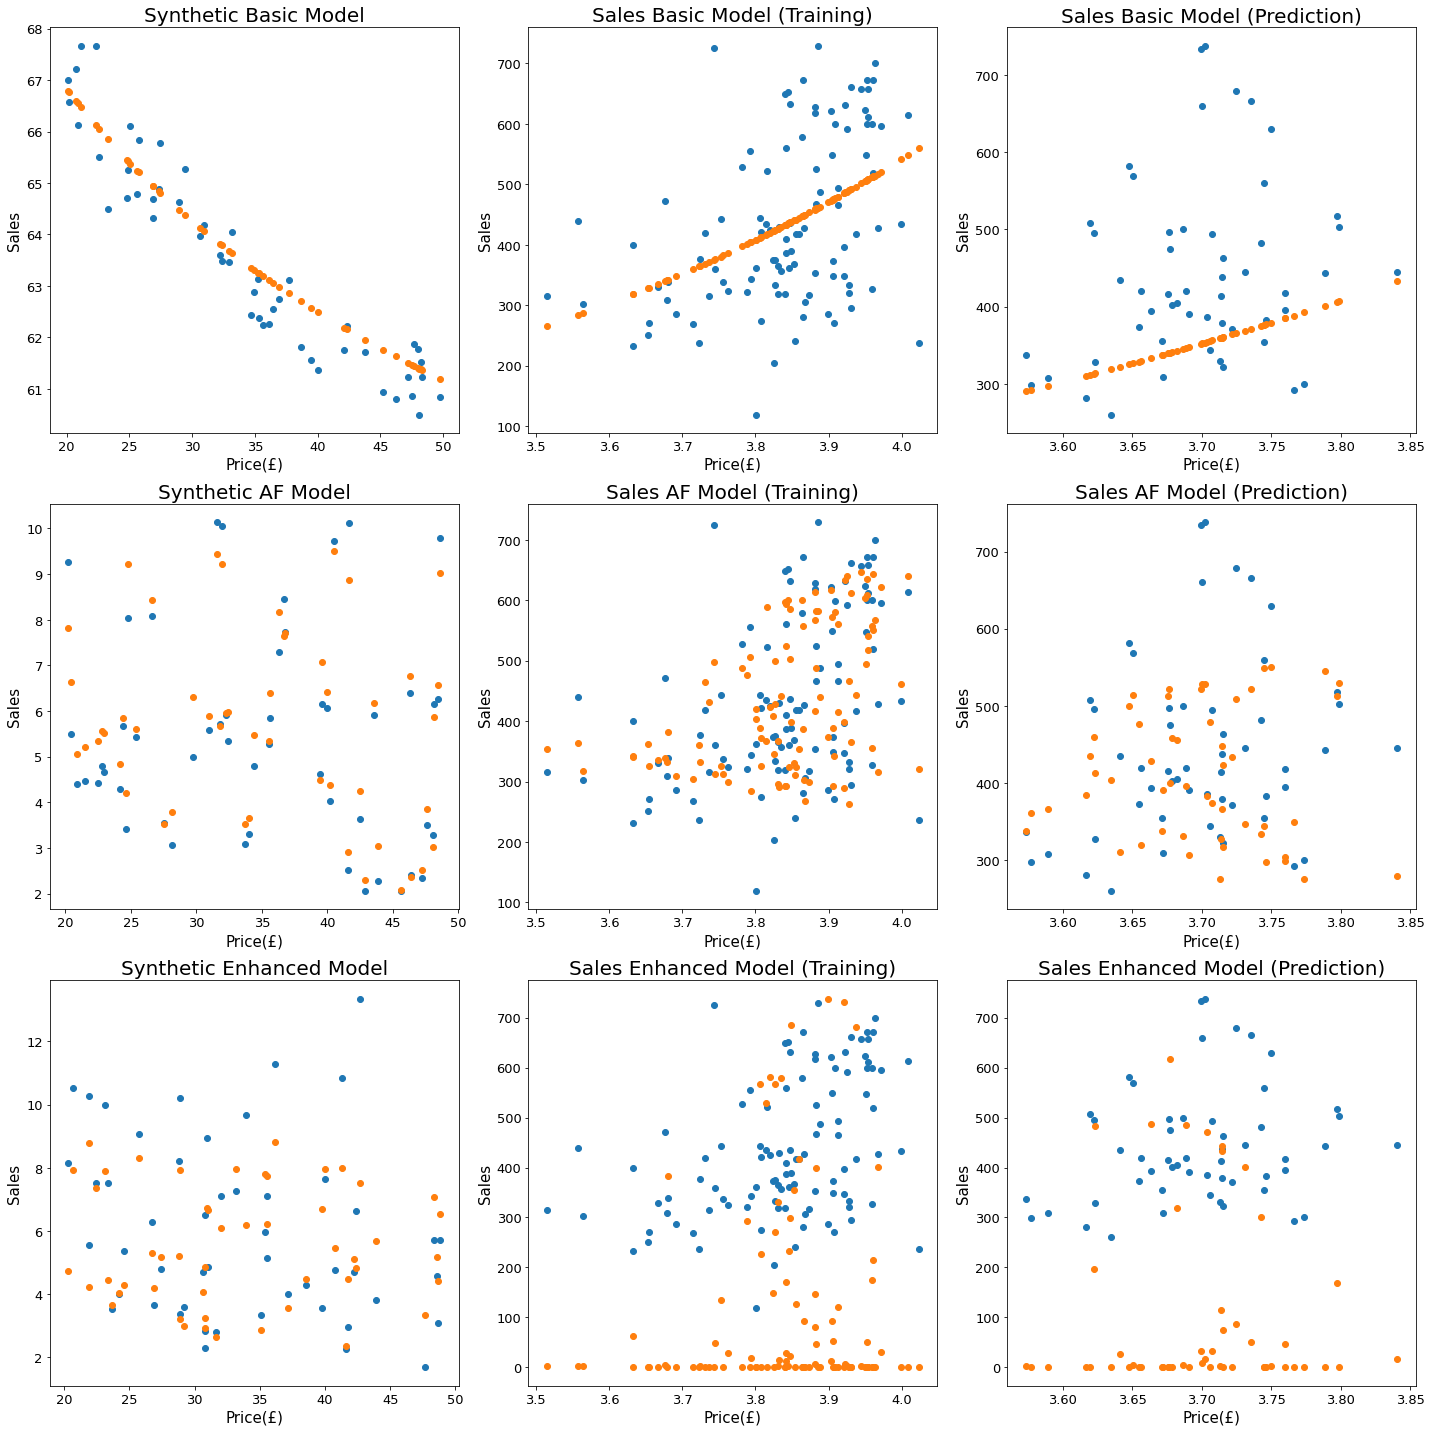

In [441]:
fig, ax = plt.subplots(3, 3,figsize=(20,20))

#Model 1
ax[0,0].scatter(Xsim1[:,0],dsim1)
ax[0,0].scatter(Xsim1[:,0],model1(Xsim1,est_params))
ax[0,0].set_xlabel('Price(£)', fontsize=15)
ax[0,0].set_ylabel('Sales', fontsize=15)
ax[0,0].set_title('Synthetic Basic Model', fontsize=20)
ax[0,0].tick_params(axis='both', labelsize=13)

ax[0,1].scatter(X1[:,0],d1)
ax[0,1].scatter(X1[:,0],model1(X1,est_params_1))
ax[0,1].set_xlabel('Price(£)', fontsize=15)
ax[0,1].set_ylabel('Sales', fontsize=15)
ax[0,1].set_title('Sales Basic Model (Training)', fontsize=20)
ax[0,1].tick_params(axis='both', labelsize=13)

ax[0,2].scatter(X1_test[:,0],d1_test)
ax[0,2].scatter(X1_test[:,0],model1(X1_test,est_params_1))
ax[0,2].set_xlabel('Price(£)', fontsize=15)
ax[0,2].set_ylabel('Sales', fontsize=15)
ax[0,2].set_title('Sales Basic Model (Prediction)', fontsize=20)
ax[0,2].tick_params(axis='both', labelsize=13)

#Model 2
ax[1,0].scatter(Xsim2[:,0],dsim2)
ax[1,0].scatter(Xsim2[:,0],model_use(Xsim2,est_params2))
ax[1,0].set_xlabel('Price(£)', fontsize=15)
ax[1,0].set_ylabel('Sales', fontsize=15)
ax[1,0].set_title('Synthetic AF Model', fontsize=20)
ax[1,0].tick_params(axis='both', labelsize=13)

ax[1,1].scatter(X2[:,0],d2)
ax[1,1].scatter(X2[:,0],model_use(X2,est_params_2))
ax[1,1].set_xlabel('Price(£)', fontsize=15)
ax[1,1].set_ylabel('Sales', fontsize=15)
ax[1,1].set_title('Sales AF Model (Training)', fontsize=20)
ax[1,1].tick_params(axis='both', labelsize=13)

ax[1,2].scatter(X2_test[:,0],d2_test)
ax[1,2].scatter(X2_test[:,0],model_use(X2_test,est_params_2))
ax[1,2].set_xlabel('Price(£)', fontsize=15)
ax[1,2].set_ylabel('Sales', fontsize=15)
ax[1,2].set_title('Sales AF Model (Prediction)', fontsize=20)
ax[1,2].tick_params(axis='both', labelsize=13)

#Model3
ax[2,0].scatter(Xsim3[:,0],dsim3)
ax[2,0].scatter(Xsim3[:,0],model6b(Xsim3,est_params3))
ax[2,0].set_xlabel('Price(£)', fontsize=15)
ax[2,0].set_ylabel('Sales', fontsize=15)
ax[2,0].set_title('Synthetic Enhanced Model', fontsize=20)
ax[2,0].tick_params(axis='both', labelsize=13)

ax[2,1].scatter(X3[:,0],d3)
ax[2,1].scatter(X3[:,0],model6b(X3,est_params_3))
ax[2,1].set_xlabel('Price(£)', fontsize=15)
ax[2,1].set_ylabel('Sales', fontsize=15)
ax[2,1].set_title('Sales Enhanced Model (Training)', fontsize=20)
ax[2,1].tick_params(axis='both', labelsize=13)

ax[2,2].scatter(X3_test[:,0],d3_test)
ax[2,2].scatter(X3_test[:,0],model6b(X3_test,est_params_3))
ax[2,2].set_xlabel('Price(£)', fontsize=15)
ax[2,2].set_ylabel('Sales', fontsize=15)
ax[2,2].set_title('Sales Enhanced Model (Prediction)', fontsize=20)
ax[2,2].tick_params(axis='both', labelsize=13)

plt.tight_layout()
plt.savefig('../Images/ModelsPrice.png')

## Decomposition

In [88]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
from matplotlib.pyplot import figure

data_prod = data[(data['Description']=='Footwear Cleaner')&(data['Channel']=='Retail - Full Price')]#.groupby(['Date'], as_index=False).agg(aggregations) 
series = data_prod[['Date','sales']].groupby(['Date']).sum()

result = seasonal_decompose(series, model='additive', period=2)

residual = pd.DataFrame(result.resid)
trend = pd.DataFrame(result.trend)
trend = trend.rename(columns={'trend':'resid'})
desc = residual.add(trend,fill_value=0)

data_prod = data_prod.merge(residual, on='Date') 

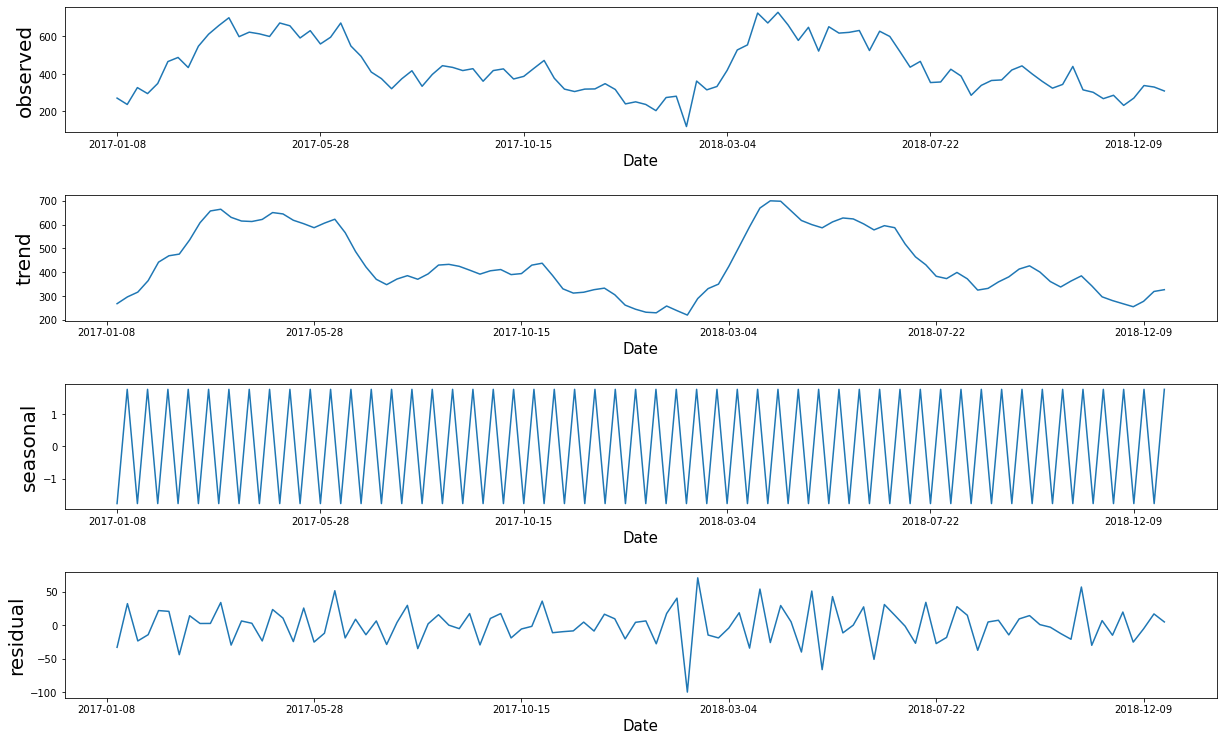

In [105]:

observed = result.observed
trend = result.trend
seasonal = result.seasonal
residual = result.resid

df = pd.DataFrame({"observed":observed,"trend":trend, "seasonal":seasonal,"residual":residual})
fig, axes = plt.subplots(nrows=4,ncols=1, figsize=(20, 12))

for i, ax in enumerate(axes):
    ax = df.iloc[:,i].plot(ax=ax)
    #ax.set_xticks( minor=False)
    ax.set_ylabel(df.iloc[:,i].name, fontsize=20)
    ax.set_xlabel('Date', fontsize=15)
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.5)    
plt.savefig('../Images/decomp.png')

Residual plot of Basic model

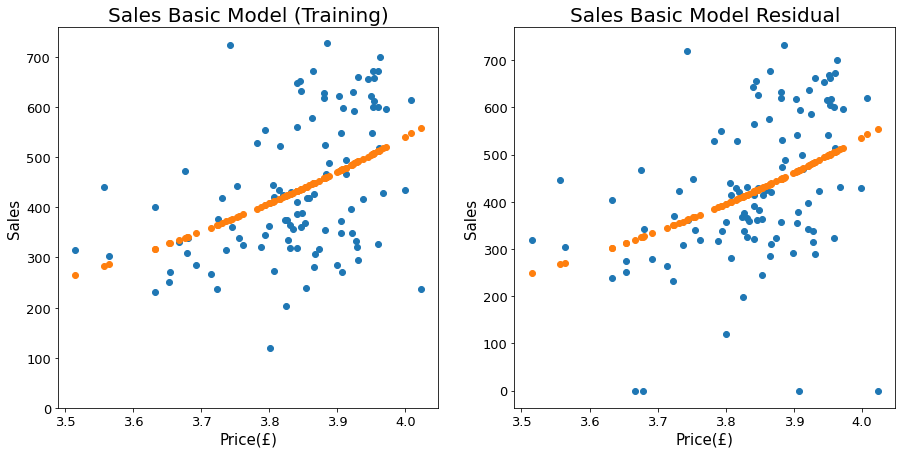

In [421]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,7))

ax1.scatter(X1[:,0],d1)
ax1.scatter(X1[:,0],model1(X1,est_params_1))
ax1.set_xlabel('Price(£)', fontsize=15)
ax1.set_ylabel('Sales', fontsize=15)
ax1.set_title('Sales Basic Model (Training)', fontsize=20)
ax1.tick_params(axis='both', labelsize=13)
ax1.set_yticks(range(0,800,100))


ax2.scatter(X1res,d1res)
ax2.scatter(X1res,model1(X1res,est_params_1res))
ax2.set_xlabel('Price(£)', fontsize=15)
ax2.set_ylabel('Sales', fontsize=15)
ax2.set_title('Sales Basic Model Residual', fontsize=20)
ax2.tick_params(axis='both', labelsize=13)
ax2.set_yticks(range(0,800,100))


plt.savefig('../Images/residual.png')
plt.show()

Other types of decompositions

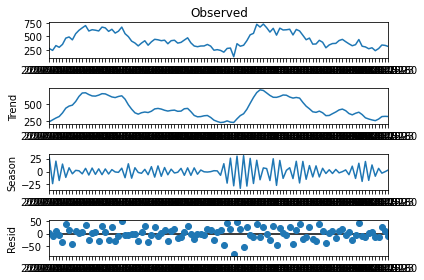

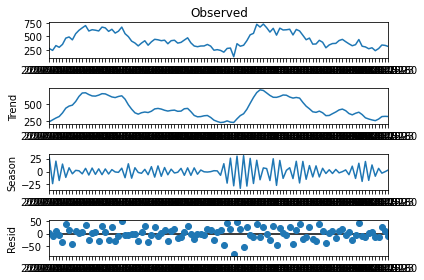

In [303]:
from statsmodels.tsa.seasonal import STL
from matplotlib import pyplot
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

data_prod = data[(data['Description']=='Footwear Cleaner')&(data['Channel']=='Retail - Full Price')]#.groupby(['Date'], as_index=False).agg(aggregations) 
series = data_prod[['Date','sales']].groupby(['Date']).sum()

result = STL(series, period=2).fit()

result.plot()

## Demand plot

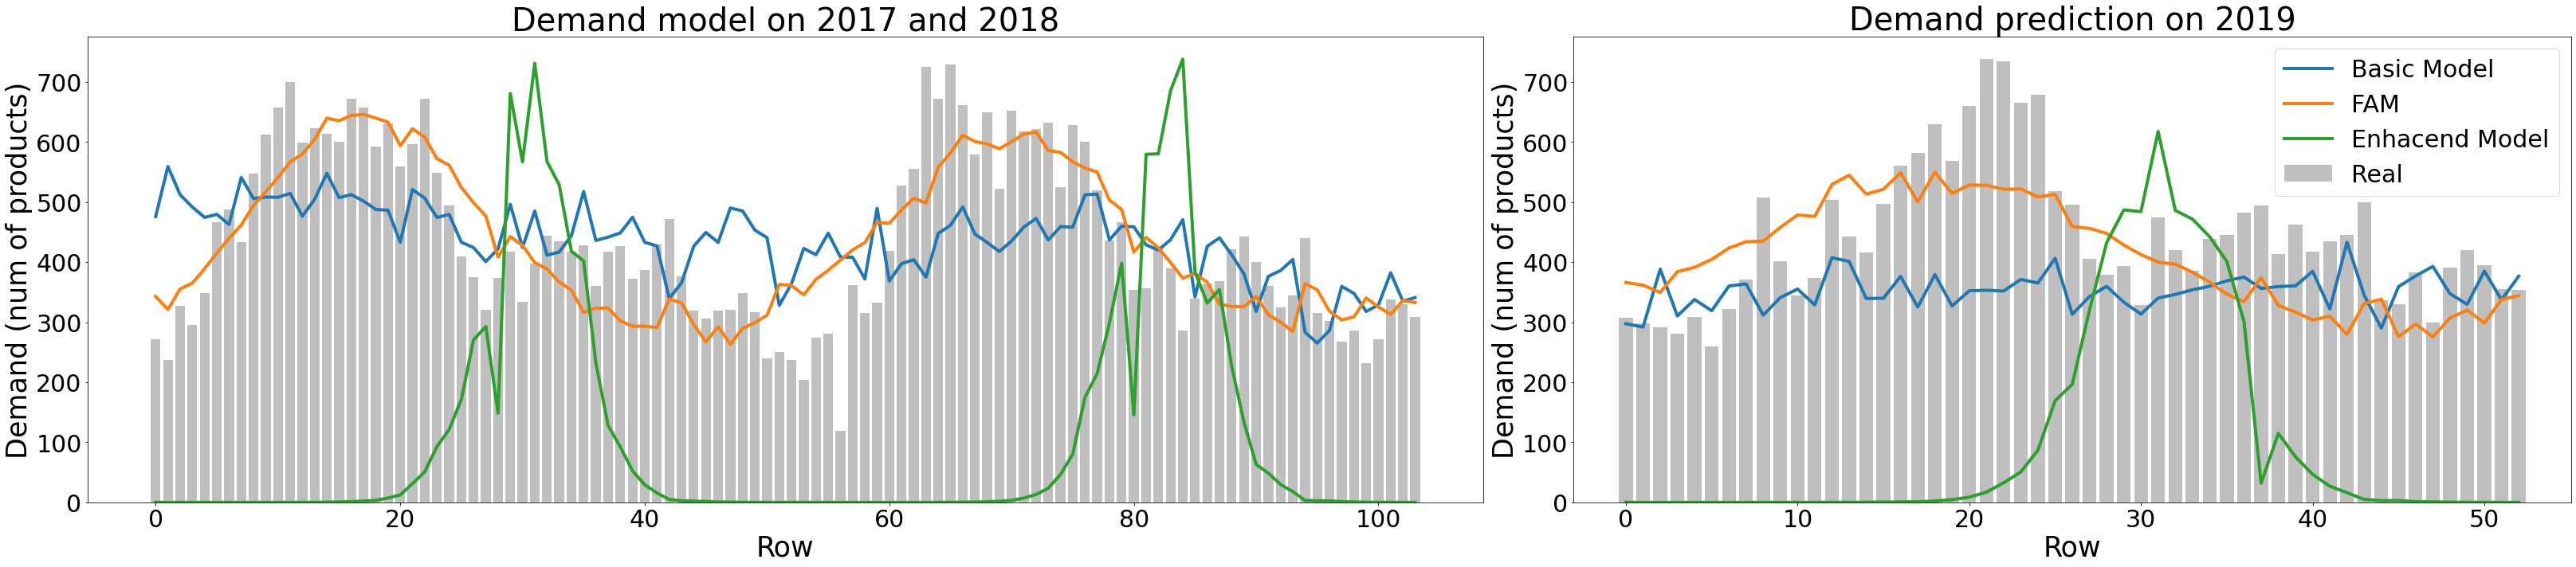

In [442]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(45,10),gridspec_kw={'width_ratios': [7, 5]})
ax1.set_title('Demand model on 2017 and 2018', fontsize=40)
ax1.bar(np.arange(len(d1)),d1,linewidth=1,color ='#bfbfbf', label='Real')
ax1.plot(model1(X1,est_params_1),linewidth=4, label='Basic Model')
ax1.plot(model6b(X2,est_params_2),linewidth=4, label='FAM')
ax1.plot(model6b(X3,est_params_3),linewidth=4, label='Enhacend Model')
ax1.set_ylabel('Demand (num of products)', fontsize=35)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_xlabel('Row', fontsize=35)

ax2.set_title('Demand prediction on 2019', fontsize=40)
ax2.bar(np.arange(len(d1_test)),d1_test,linewidth=1,color ='#bfbfbf', label='Real')
ax2.plot(model1(X1_test,est_params_1),linewidth=4, label='Basic Model')
ax2.plot(model6b(X2_test,est_params_2),linewidth=4, label='FAM')
ax2.plot(model6b(X3_test,est_params_3), linewidth=4,label='Enhacend Model')
ax2.set_ylabel('Demand (num of products)', fontsize=35)
ax2.set_xlabel('Row', fontsize=35)
ax2.tick_params(axis='both', labelsize=30)
ax2.legend(fontsize=30)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.7)
plt.tight_layout()
plt.savefig('../Images/Demandcomparison.png')

Other products scores

In [392]:
params = [[ 4.53594017, -0.05124563 , 0.02194488 ,-7.89849925 , 1.90392741 ,-0.50147992, 6.10206914],
          [ 5.69809885,  0.07168655,  0.07552127,  4.08196248,  0.77508131, -0.34857881,0.21543885],
          [ 6.96012301,  2.21707027 ,-0.54807581, 0.485734  ,  0.12571866 ,-3.70064631, 0.22581988],
          [ 3.35511025, -0.69440983 , 0.27833327 , 0.43174277 ,-0.30838678 ,-0.1395524, 0.41326461]]
rest_prod = ['Suede And Nubuck Brush',"Hotter Women's Insoles",'Renovating Cream', 'Wax Oil']

In [429]:
for i in range(0,4):
    
    data_prod = data[(data['Description']==rest_prod[i])&(data['Channel']=='Retail - Full Price')].sort_values('Date')
    data_prod_test = data_test[(data_test['Description']==rest_prod[i])&(data_test['Channel']=='Retail - Full Price')].sort_values('Date')

    #real data preparation prod 1
    data_prod1 = data_prod[['Price','Week_sin','Week_cos','Discount','prev_mean_price','sales']]
    data_prod1_test = data_prod_test[['Price','Week_sin','Week_cos','Discount','prev_mean_price','sales']]
    X1 = data_prod1.values[:,:-1]
    d1 = data_prod1.values[:,-1]
    X1_test = data_prod1_test.values[:,:-1]
    d1_test = data_prod1_test.values[:,-1]
    est_params_1 = params[i]

    score_rov = r2_score(d1,model6b(X1,est_params_1))
    score2_rov = mean_squared_error(d1,model6b(X1,est_params_1))
    score3_rov = mean_absolute_error(d1,model6b(X1,est_params_1))
    score4_rov = mean_absolute_percentage_error(d1,model6b(X1,est_params_1))
    print(rest_prod[i],'& Training & ',score2_rov, ' & ',score3_rov, ' & ',score4_rov)
    
    score_rov = r2_score(d1_test,model6b(X1_test,est_params_1))
    score2_rov = mean_squared_error(d1_test,model6b(X1_test,est_params_1))
    score3_rov = mean_absolute_error(d1_test,model6b(X1_test,est_params_1))
    score4_rov = mean_absolute_percentage_error(d1_test,model6b(X1_test,est_params_1))
    print(rest_prod[i],'& Test & ', score2_rov, ' & ',score3_rov, ' & ',score4_rov)


Suede And Nubuck Brush & Training &  2810.497526411968  &  42.38263763108844  &  0.1867072587285941
Suede And Nubuck Brush & Test &  4223.514709556776  &  54.0347081083843  &  0.2543356811385702
Hotter Women's Insoles & Training &  5034.985588835236  &  57.61061613271072  &  0.20329471513346592
Hotter Women's Insoles & Test &  3034.727307419257  &  44.69333193606654  &  0.14977949098772575
Renovating Cream & Training &  68602.58319586005  &  205.64826938103695  &  0.20319887404175146
Renovating Cream & Test &  57684.170267966714  &  204.90409160308886  &  0.1829556997183859
Wax Oil & Training &  195.2080746279288  &  10.43580829342573  &  0.3992903987894476
Wax Oil & Test &  790.4652150884428  &  25.146067789121165  &  0.4526508178907725


Plots for different betas and alphas

In [355]:
P = np.arange(1,40)
w0 = 1
w1 = 1
w2 = 1

D = np.exp(w0 - w1*np.log(P))
D

array([2.71828183, 1.35914091, 0.90609394, 0.67957046, 0.54365637,
       0.45304697, 0.38832598, 0.33978523, 0.30203131, 0.27182818,
       0.24711653, 0.22652349, 0.2090986 , 0.19416299, 0.18121879,
       0.16989261, 0.15989893, 0.15101566, 0.14306746, 0.13591409,
       0.12944199, 0.12355826, 0.11818617, 0.11326174, 0.10873127,
       0.1045493 , 0.1006771 , 0.09708149, 0.09373386, 0.09060939,
       0.08768651, 0.08494631, 0.08237218, 0.07994947, 0.0776652 ,
       0.07550783, 0.07346708, 0.07153373, 0.06969953])

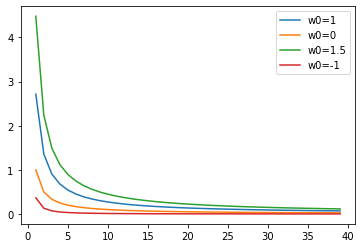

In [340]:
plt.plot(P,np.exp(w0 - w1*np.log(P)), label='w0=1')
plt.plot(P,np.exp( - w1*np.log(P)), label='w0=0')
plt.plot(P,np.exp(1.5 - w1*np.log(P)), label='w0=1.5')
plt.plot(P,np.exp(-1 - 1.5*np.log(P)), label='w0=-1')


plt.legend()

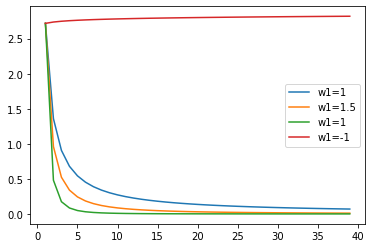

In [341]:
plt.plot(P,np.exp(w0 - w1*np.log(P)), label='w1=1')
plt.plot(P,np.exp(w0 - 1.5*np.log(P)), label='w1=1.5')
plt.plot(P,np.exp(w0 - 2.5*np.log(P)), label='w1=1')
plt.plot(P,np.exp(w0 + 0.01*np.log(P)), label='w1=-0.01')
plt.legend()

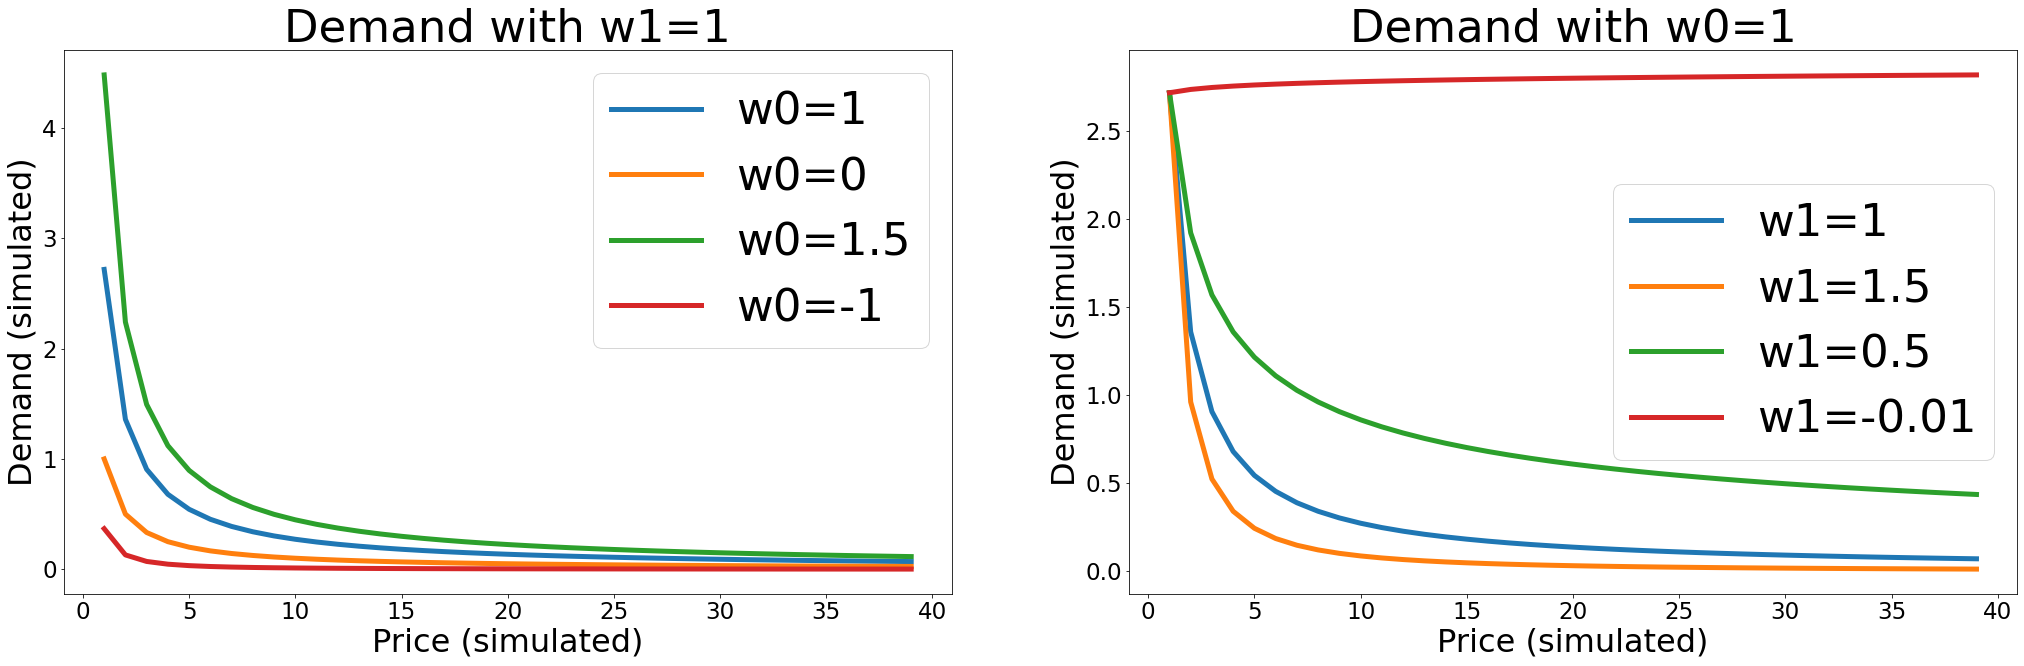

In [432]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(35,10))

ax1.set_title('Demand with w1=1', fontsize=45)
ax1.plot(P,np.exp(w0 - w1*np.log(P*w2)),linewidth=5, label='w0=1')
ax1.plot(P,np.exp( - w1*np.log(P*w2)),linewidth=5, label='w0=0')
ax1.plot(P,np.exp(1.5 - w1*np.log(P*w2)),linewidth=5, label='w0=1.5')
ax1.plot(P,np.exp(-1 - 1.5*np.log(P*w2)),linewidth=5, label='w0=-1')
ax1.tick_params(axis='both', labelsize=23)
ax1.set_ylabel('Demand (simulated)', fontsize=32)
ax1.set_xlabel('Price (simulated)', fontsize=32)
ax1.legend(fontsize=45)

ax2.set_title('Demand with w0=1', fontsize=45)
ax2.plot(P,np.exp(w0 - w1*np.log(P*w2)),linewidth=5, label='w1=1')
ax2.plot(P,np.exp(w0 - 1.5*np.log(P*w2)),linewidth=5, label='w1=1.5')
ax2.plot(P,np.exp(w0 - 0.5*np.log(P*w2)),linewidth=5, label='w1=0.5')
ax2.plot(P,np.exp(w0 + 0.01*np.log(P*w2)),linewidth=5, label='w1=-0.01')
ax2.tick_params(axis='both', labelsize=23)
ax2.set_ylabel('Demand (simulated)', fontsize=32)
ax2.set_xlabel('Price (simulated)', fontsize=32)
ax2.legend(fontsize=45)


plt.savefig('../Images/demandtest.png')